Copyright (c) Contributors to the PhysLight Project

SPDX-License-Identifier: Apache-2.0

# Spectral Sensitivity Measurements

This notebook shows how to load and inspect the spectral sensitivity curves for different cameras. The data is stored as JSON following the rawtoaces schema.



In [21]:
import colour
from colour import MultiSpectralDistributions, SpectralDistribution, SpectralShape, sd_to_XYZ
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Loading the data

This is the important function - we just load the data and bung it straight into a MultiSpectralDistriution from the colour library. The data is stored as a dict of `{'wavelength': [r, g, b]}`, e.g.: 
```
{
    "380": [
        0.0010345341, 
        0.0013633471, 
        0.0011342563
    ], 
    "390": [
        0.0009932282, 
        0.0010626995, 
        0.0020822824
    ],
    # ...
    "720": [
        0.0014271278, 
        0.0006711098, 
        0.0002201598
    ]
}
```

In [22]:
def load_camera_data(camera_json):
    import requests
    import json

    with open(camera_json, 'r') as f:
        json = json.load(f)
        cmf_5d = MultiSpectralDistributions(json['spectral_data']['data']['main'], labels=['r_bar', 'g_bar', 'b_bar'],
                                            name='{} {}'.format(
        json['header']['manufacturer'],
        json['header']['model']
        ))
        return cmf_5d
        

## Displaying the data

The rest of the notebook just graphs the sensitivity curves and draws Macbeth charts using them.

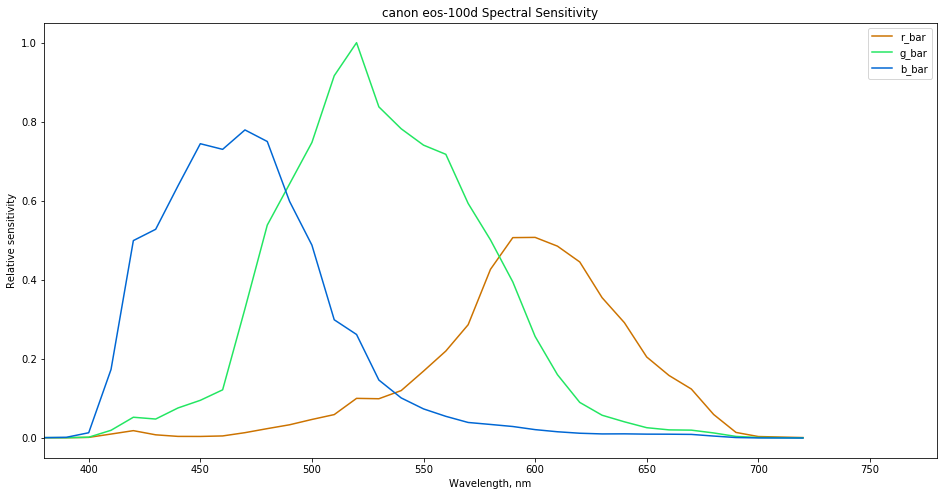

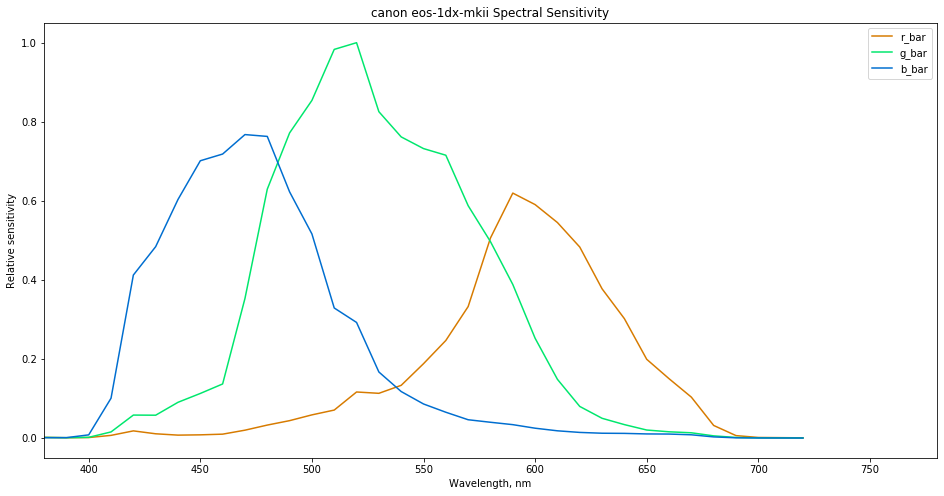

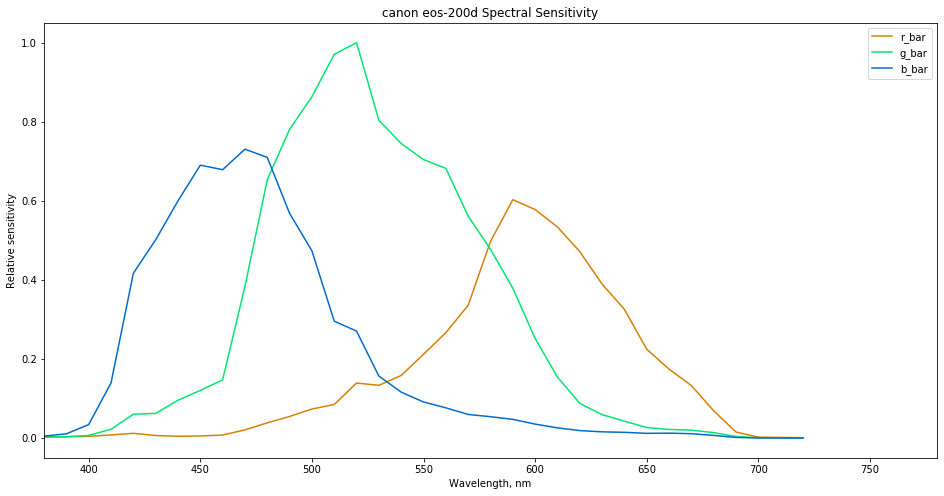

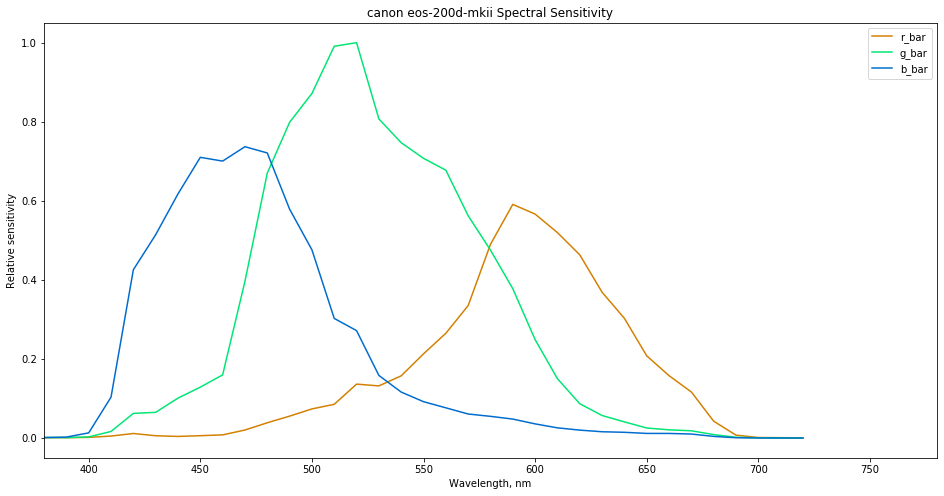

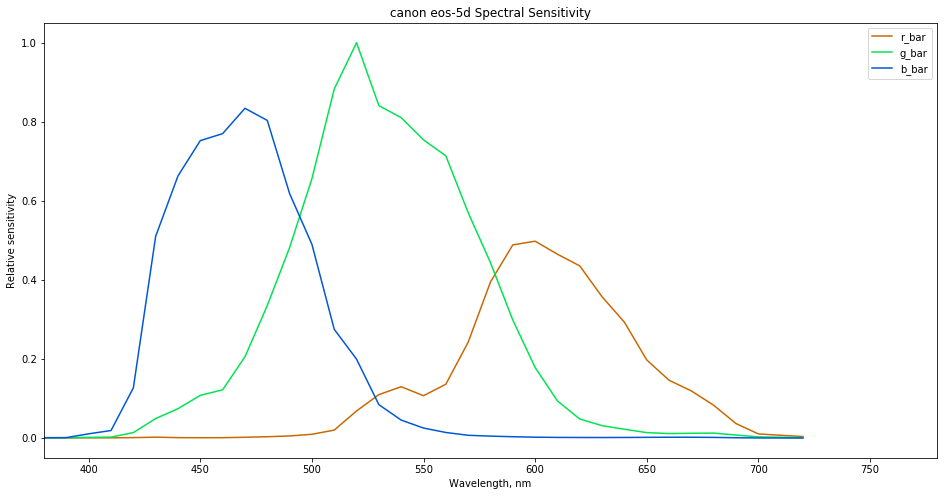

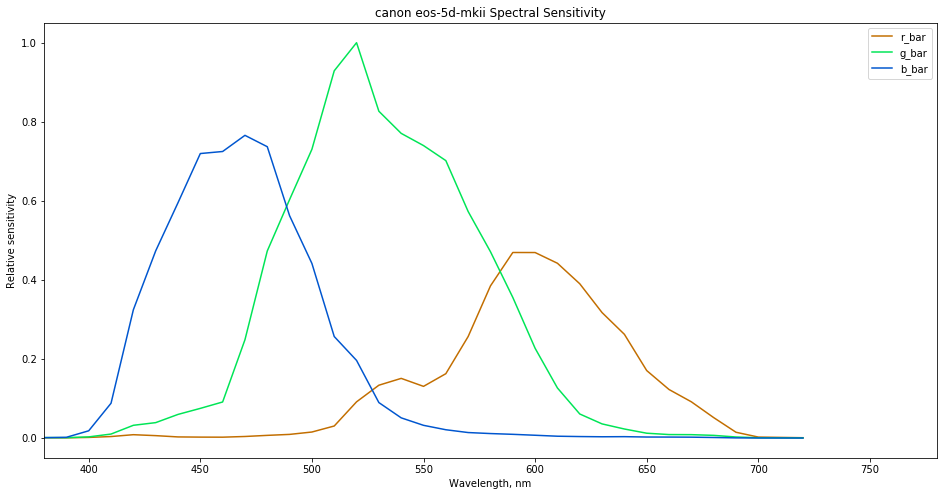

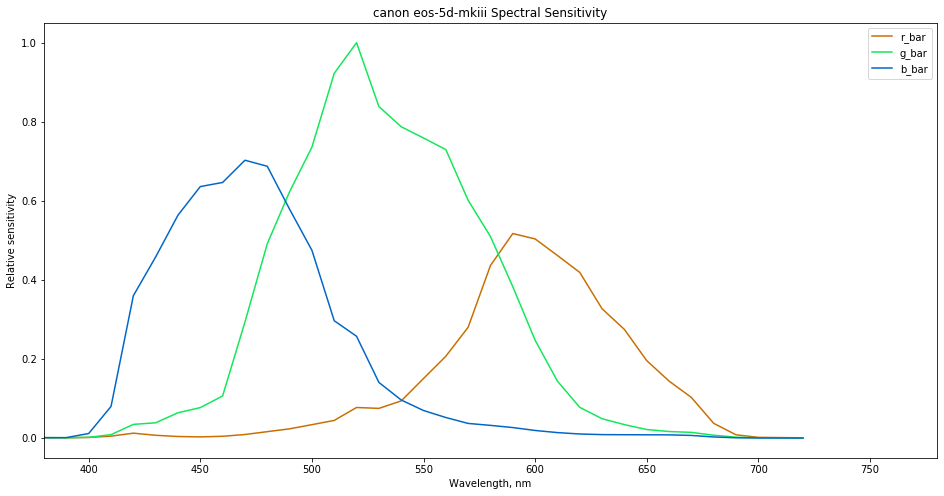

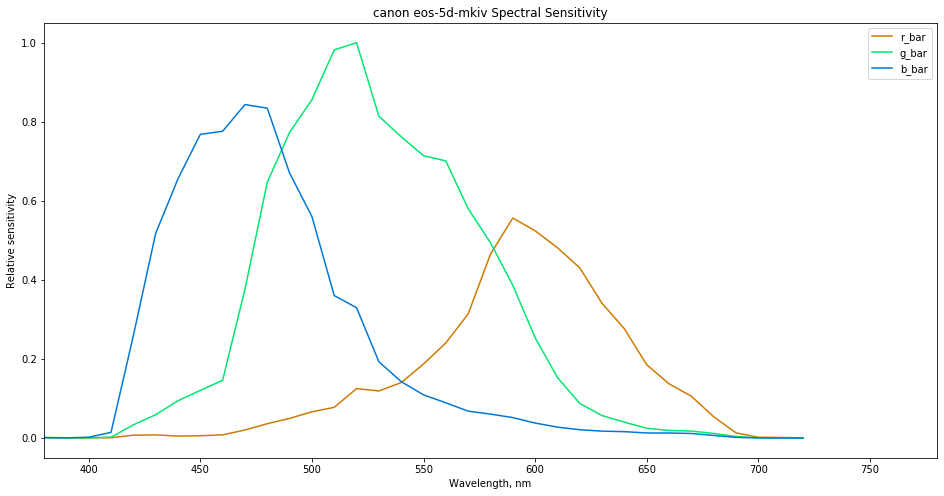

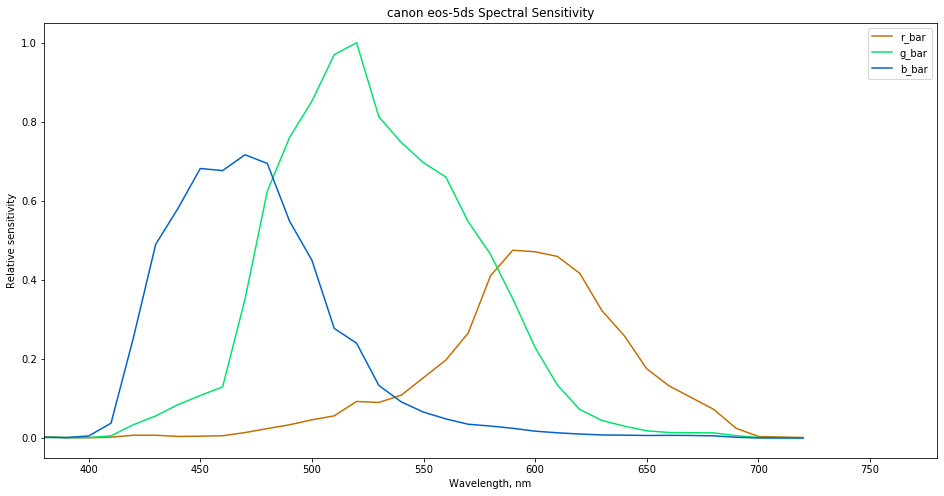

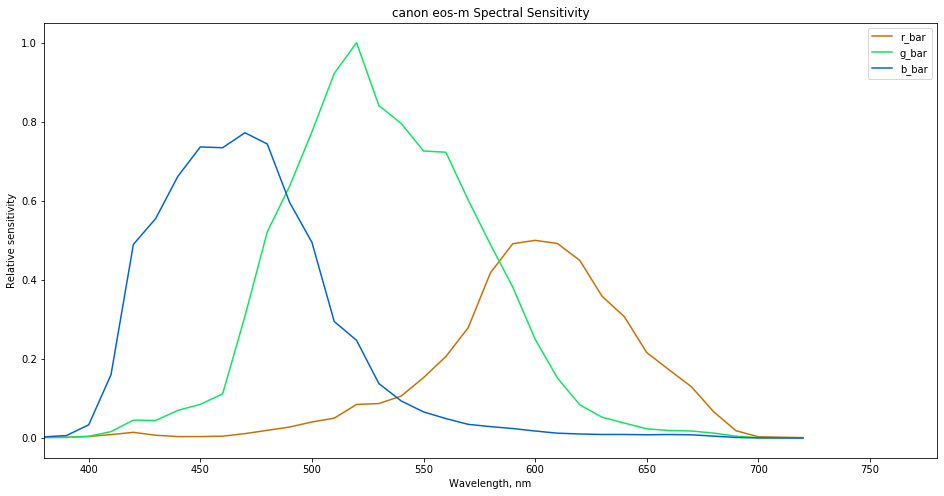

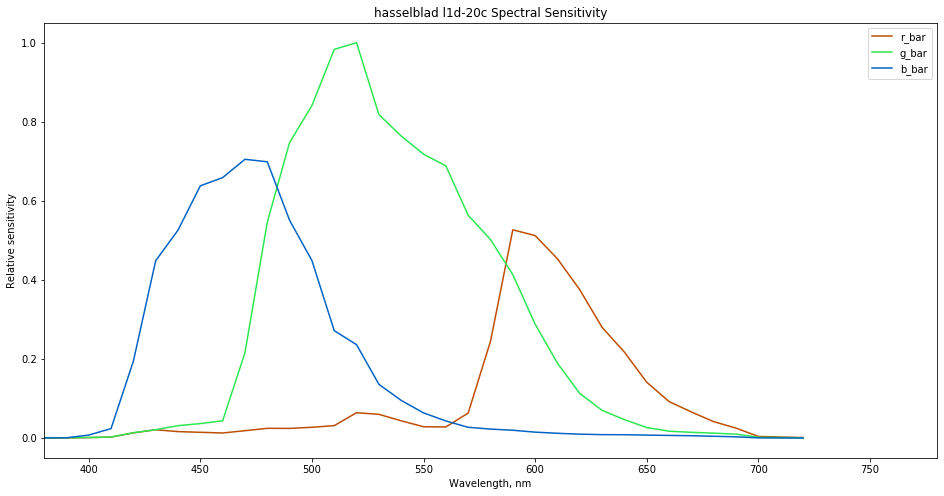

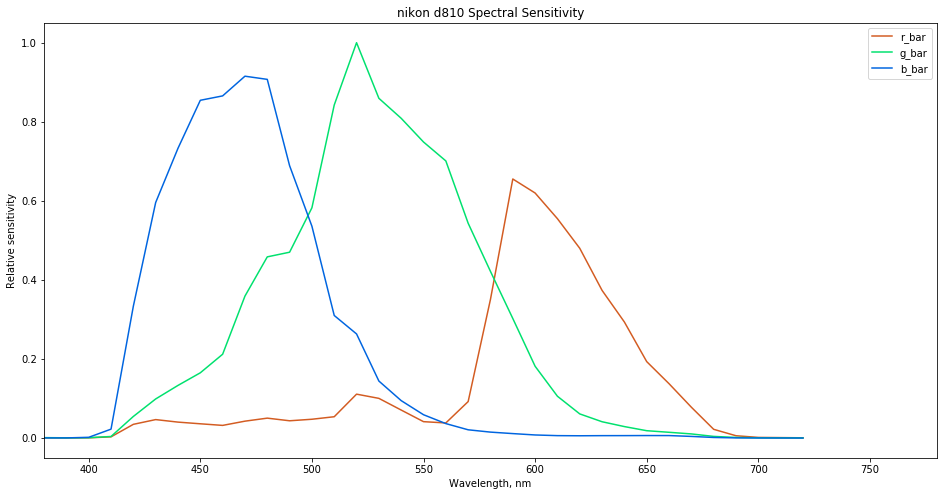

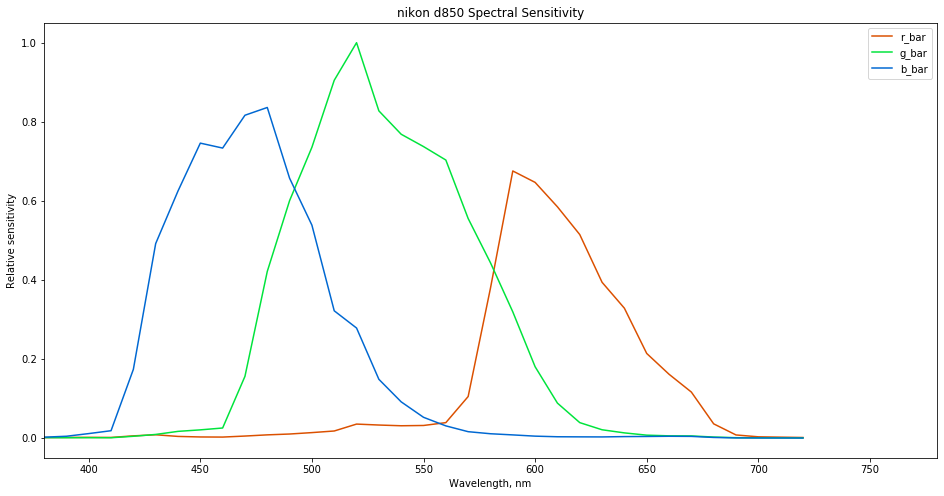

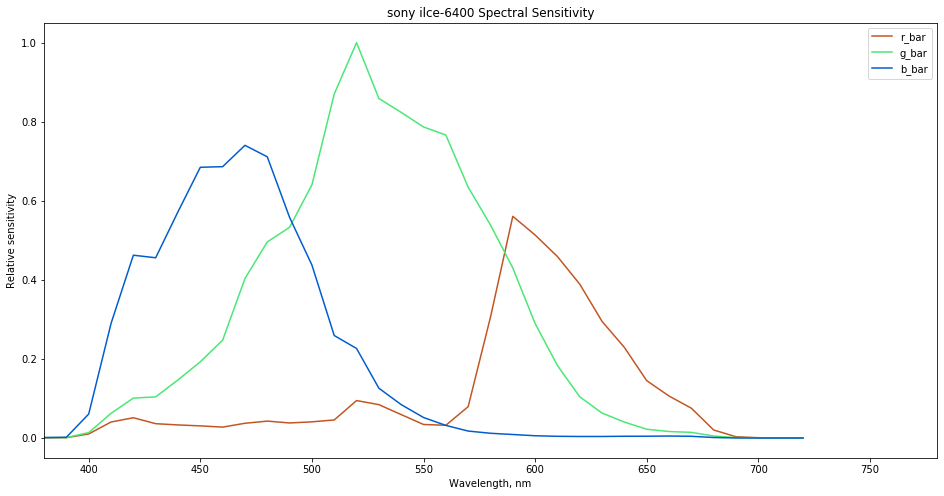

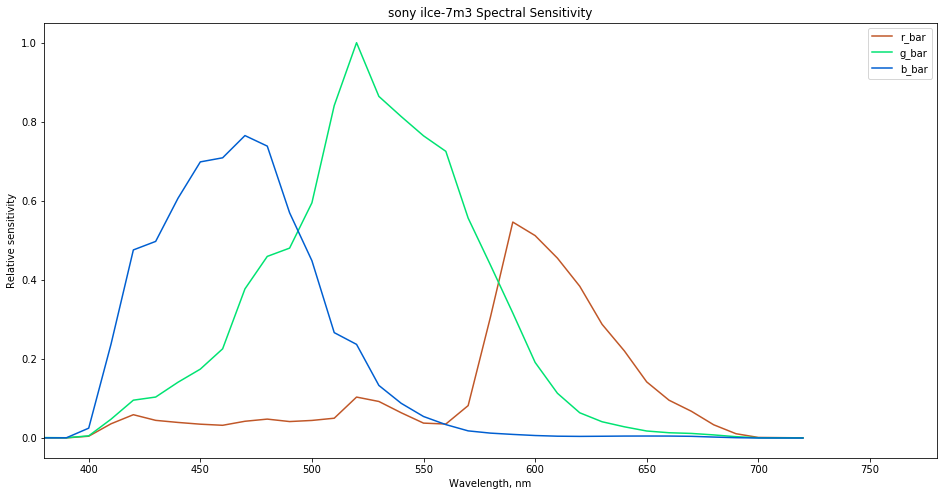

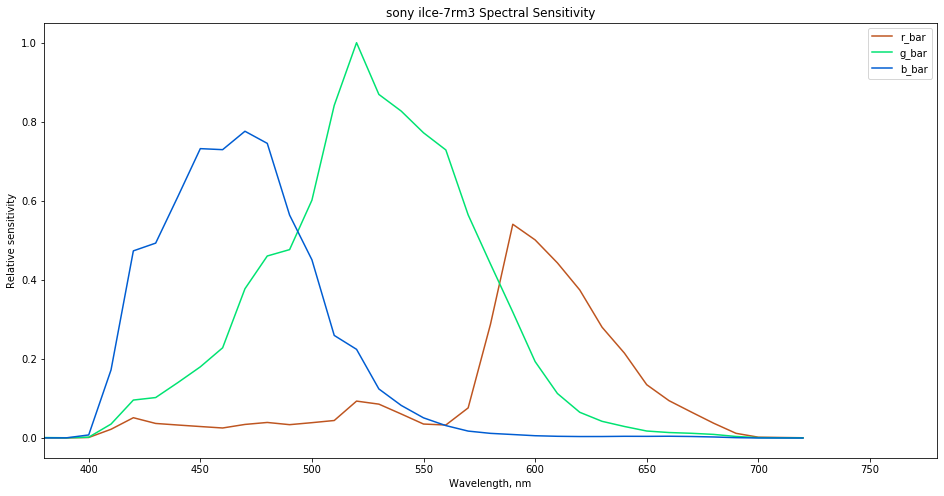

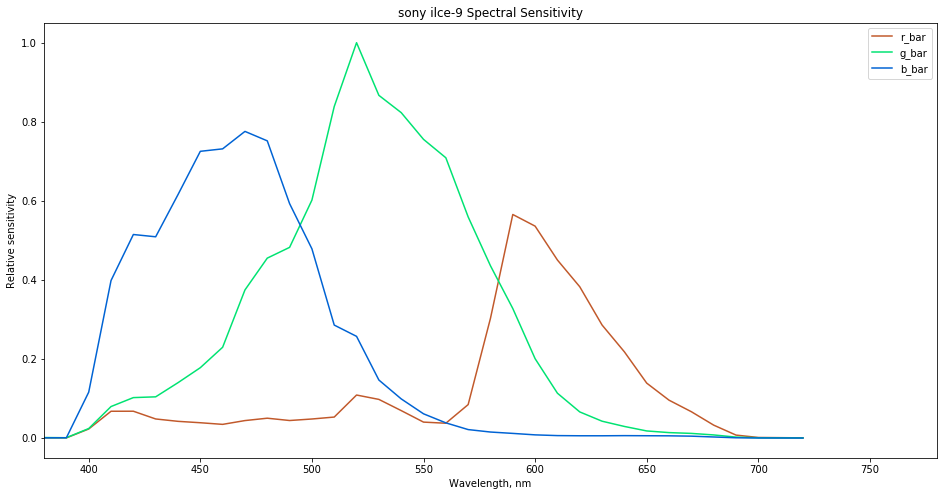

In [23]:
def draw_curves(cmf_5d):
    # Plot the curves
    from colour import SpectralDistribution
    
    r = colour.sd_to_XYZ(SpectralDistribution(data=cmf_5d.values[:,0], domain=cmf_5d.wavelengths)) / 100
    r = np.clip(colour.XYZ_to_sRGB(r), 0, 1)
    g = colour.sd_to_XYZ(SpectralDistribution(data=cmf_5d.values[:,1], domain=cmf_5d.wavelengths)) / 100
    g = np.clip(colour.XYZ_to_sRGB(g), 0, 1)
    b = colour.sd_to_XYZ(SpectralDistribution(data=cmf_5d.values[:,2], domain=cmf_5d.wavelengths)) / 100
    b = np.clip(colour.XYZ_to_sRGB(b), 0, 1)

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlim(380, 780)
    ax.set_xlabel('Wavelength, nm')
    ax.set_ylabel('Relative sensitivity')
    ax.plot(cmf_5d.wavelengths, cmf_5d.values[:,0], color=r)
    ax.plot(cmf_5d.wavelengths, cmf_5d.values[:,1], color=g)
    ax.plot(cmf_5d.wavelengths, cmf_5d.values[:,2], color=b)
    plt.title('{} Spectral Sensitivity'.format(cmf_5d.name))
    plt.legend(['r_bar', 'g_bar', 'b_bar'])

draw_curves(load_camera_data('canon_eos-100d_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-1dx-mkii_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-200d_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-200d-mkii_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-5d_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-5d-mkii_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-5d-mkiii_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-5d-mkiv_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-5ds_380_720_10.json'))
draw_curves(load_camera_data('canon_eos-m_380_720_10.json'))
draw_curves(load_camera_data('hasselblad_l1d-20c_380_720_10.json'))
draw_curves(load_camera_data('nikon_d810_380_720_10.json'))
draw_curves(load_camera_data('nikon_d850_380_720_10.json'))
draw_curves(load_camera_data('sony_ilce-6400_380_720_10.json'))
draw_curves(load_camera_data('sony_ilce-7m3_380_720_10.json'))
draw_curves(load_camera_data('sony_ilce-7rm3_380_720_10.json'))
draw_curves(load_camera_data('sony_ilce-9_380_720_10.json'))

In [31]:
# Convert a spectral distribution to camera RGB space using the given CMFs and
# illuminant.
# This is just a wrapper over sd_to_XYZ to make the name less confusing
def sd_to_CameraRGB(sd, cmf, illuminant):
  return sd_to_XYZ(sd, cmf, illuminant)


# Convert a SpectralDistribution to CIE XYZ via Camera RGB space
def sd_to_CameraRGB_to_XYZ(sd, cmf, src_illuminant_sd, rgb_to_xyz, rgb_white):
  # Convert to Camera RGB under the source illuminant and divide by the white 
  # point in Camera RGB
  rgb = sd_to_CameraRGB(sd, cmf, src_illuminant_sd) / (100 * rgb_white)
  # Convert to XYZ using the supplied matrix
  return colour.RGB_to_XYZ(rgb, xy_d65, xy_d65, rgb_to_xyz)

# Solve the Camera RGB to XYZ matrix by linear least squares on the set of 
# swatches given under the given illuminant SpectralDistribution
def solve_matrix(cmf, src_illuminant_sd, dst_illuminant_sd, rgb_white, swatches=None):
  RGB = []
  XYZ = []

  if swatches is None:
    swatches = colour.COLOURCHECKERS_SDS['BabelColor Average'].values()

  for sd in swatches:
    xyz = sd_to_XYZ(sd, illuminant=dst_illuminant_sd) / 100
    rgb = sd_to_CameraRGB(sd, cmf, src_illuminant_sd) / (100 * rgb_white)

    RGB.append(rgb)
    XYZ.append(xyz)

  return np.linalg.lstsq(RGB, XYZ, rcond=None)[0].T

# Convert the BabelColor Average chart to XYZ via Camera RGB
def create_chart(cmf, src_illuminant_sd, dst_illuminant_sd, rgb_to_xyz, rgb_white):
  checkersd = colour.COLOURCHECKERS_SDS['BabelColor Average']
  chart_data = []
  for name, sd in checkersd.items():
    xyz_cam = sd_to_CameraRGB_to_XYZ(sd, cmf, src_illuminant_sd, rgb_to_xyz, rgb_white)
    chart_data.append(colour.XYZ_to_sRGB(xyz_cam))

  return chart_data


# Draw macbeth chart for comparison
def draw_chart(swatches, labels=None, figsize=20):
  import numpy as np
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  from matplotlib.collections import PatchCollection

  swatches = np.array(swatches)

  if len(swatches.shape) != 3:
    raise TypeError('swatches must be a list of lists of colors, i.e. shape is (N, 24, 3)')

  if swatches.shape[0] > 5:
    raise ValueError('only 5 sets supported')

  num_sets = swatches.shape[0]

  fig, ax = plt.subplots(figsize=(figsize, figsize))
  ax.set_aspect(1)
  ax.set_ylim((0.0, 0.8))
  patches = [[] for s in range(num_sets)]
  deltas = [[] for s in range(num_sets)]
  num_cols = 6
  num_rows = 4
  gap = 0.03
  offset = 0.04
  base_size = 4
  size = (1 - offset * 2 - (gap * (num_cols-1))) / num_cols
  for row in range(0, num_rows):
    for col in range(0, num_cols):
      y = (num_rows - row - 1) * (size + gap) + offset * base_size
      x = col * (size + gap) + offset

      if num_sets == 1:
        patches[0].append(Rectangle((x, y), size, size))
      elif num_sets == 2:
        # draw the second patch as the background, then the first as the inset
        patches[0].append(Rectangle((x, y), size, size))
        s = size/2
        patches[1].append(Rectangle((x+s/2, y+s/2), s, s))
        pass
      elif num_sets == 3:
        # draw the first two sets as left and right halves of the bg, then the
        # last as the inset
        s = size/2
        patches[0].append(Rectangle((x, y), s, size))
        patches[1].append(Rectangle((x+s, y), s, size))
        patches[2].append(Rectangle((x+s/2, y+s/2), s, s))
      elif num_sets == 4:
        # Same but split the right half into quarters
        s = size/2
        patches[0].append(Rectangle((x, y), s, size))
        patches[1].append(Rectangle((x+s, y), s, s))
        patches[2].append(Rectangle((x+s, y+s), s, s))
        patches[3].append(Rectangle((x+s/2, y+s/2), s, s))
      elif num_sets == 5:
        s = size/2
        patches[0].append(Rectangle((x, y), s, s))
        patches[1].append(Rectangle((x, y+s), s, s))
        patches[2].append(Rectangle((x+s, y), s, s))
        patches[3].append(Rectangle((x+s, y+s), s, s))
        patches[4].append(Rectangle((x+s/2, y+s/2), s, s))

  patches = [p for s in patches for p in s]

  patches.insert(0, Rectangle((0, 0), 1, size*num_rows + offset * (base_size+1) + gap * (num_rows-1)))

  coll = PatchCollection(patches)
  colors = swatches.reshape(-1, swatches.shape[-1])
  colors = np.insert(colors, 0, [0.1, 0.1, 0.1], 0)
  colors = np.clip(colors, 0.0, 1.0)
  coll.set_color(colors)
  ax.add_collection(coll)

  # Calculate deltas
  def sRGB_to_Lab(rgb):
    xyz = colour.sRGB_to_XYZ(rgb)
    return colour.XYZ_to_Lab(xyz)

  labs = [np.array(list(map(sRGB_to_Lab, s))) for s in swatches]

  def print_delta(d, r):
      plt.text(offset + 0.62, offset * float(r)/2 * 1.2, 
                u'ΔE min: %.2f max: %.2f mean: %.2f std: %.2f' 
                % (d.min(), d.max(), np.mean(d), np.std(d)), 
               color='grey', size=textsize*0.7)


  if labels is not None:
    textsize = figsize
    c2 = 0.2
    if num_sets == 1:
      plt.text(offset, offset * 5.0/2 * 1.2, labels[0], color='white', size=textsize)
    elif num_sets == 2:
      deltas = [colour.delta_E(l, labs[-1]) for l in labs[:-1]]
      plt.text(offset, offset * 5.0/2 * 1.2, 'Background:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2, labels[0], color='white', size=textsize)
      print_delta(deltas[0], 5)
      plt.text(offset, offset * 4.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2, labels[1], color='white', size=textsize)
    elif num_sets == 3:
      deltas = [colour.delta_E(l, labs[-1]) for l in labs[:-1]]
      plt.text(offset, offset * 5.0/2 * 1.2, 'Left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2,  labels[0], color='white', size=textsize)
      print_delta(deltas[0], 5)
      plt.text(offset, offset * 4.0/2 * 1.2, 'Right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2, labels[1], color='white', size=textsize)
      print_delta(deltas[1], 4)
      plt.text(offset, offset * 3.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 3.0/2 * 1.2, labels[2], color='white', size=textsize)
    elif num_sets == 4:
      deltas = [colour.delta_E(l, labs[-1]) for l in labs[:-1]]
      plt.text(offset, offset * 5.0/2 * 1.2, 'Left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2,  labels[0], color='white', size=textsize)
      print_delta(deltas[0], 5)
      
      plt.text(offset, offset * 4.0/2 * 1.2, 'Bottom-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2,  labels[1], color='white', size=textsize)
      print_delta(deltas[1], 4)

      plt.text(offset, offset * 3.0/2 * 1.2, 'Top-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 3.0/2 * 1.2,  labels[2], color='white', size=textsize)
      print_delta(deltas[2], 3)

      plt.text(offset, offset * 2.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 2.0/2 * 1.2,  labels[3], color='white', size=textsize)
    elif num_sets == 5:
      deltas = [colour.delta_E(l, labs[-1]) for l in labs[:-1]]
      plt.text(offset, offset * 5.0/2 * 1.2, 'Bottom-left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2,  labels[0], color='white', size=textsize)
      print_delta(deltas[0], 5)

      plt.text(offset, offset * 4.0/2 * 1.2, 'Top-left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2,  labels[1], color='white', size=textsize)
      print_delta(deltas[1], 4)

      plt.text(offset, offset * 3.0/2 * 1.2, 'Bottom-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 3.0/2 * 1.2,  labels[2], color='white', size=textsize)
      print_delta(deltas[2], 3)

      plt.text(offset, offset * 2.0/2 * 1.2, 'Top-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 2.0/2 * 1.2,  labels[3], color='white', size=textsize)
      print_delta(deltas[3], 2)
      
      plt.text(offset, offset * 1.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 1.0/2 * 1.2,  labels[4], color='white', size=textsize)

  plt.show()
  
# Returns a tuple of (SpectralDistribution, xy) of the calculated colour
# for the given temperature. Temperature must be <= 25000.
# The returned spectral distribution is normalized such that Y=1
def calculate_whitepoint(temperature=6500.0):
  # CIE 015:2004 scale temperature so e.g. 6500 becomes 6504
  temperature = float(temperature) * 1.4388 / 1.4380

  # D is only defined over the domain [4000, 25000] so we use blackbody 
  # outside that domain
  if temperature < 4000:
    sd = colour.sd_blackbody(temperature)
  else:
    xy = colour.temperature.CCT_to_xy_CIE_D(temperature)
    sd = colour.sd_CIE_illuminant_D_series(xy)

  # Normalize such that Y=1
  xyz = sd_to_XYZ(colour.sd_ones(), illuminant=sd)
  # Calculate matching chromaticity coordinates
  xy = colour.XYZ_to_xy(xyz)
  return (sd / xyz[1], xy)

# Get a copy of BabelColor Average for plotting as CIE 1931
sd_d65, xy_d65 = calculate_whitepoint(6500.0)
bca = colour.COLOURCHECKERS['BabelColor Average']
colour.COLOURCHECKERS['CIE 1931'] = colour.characterisation.ColourChecker(name='CIE 1931', data = bca.data, illuminant = bca.illuminant)

chart_bca = []
for _, sd in colour.COLOURCHECKERS_SDS['BabelColor Average'].items():
  xyz = colour.sd_to_XYZ(sd, illuminant=sd_d65) / 100
  chart_bca.append(colour.XYZ_to_sRGB(xyz))

chart_bca = np.clip(chart_bca, 0.0, 1.0)

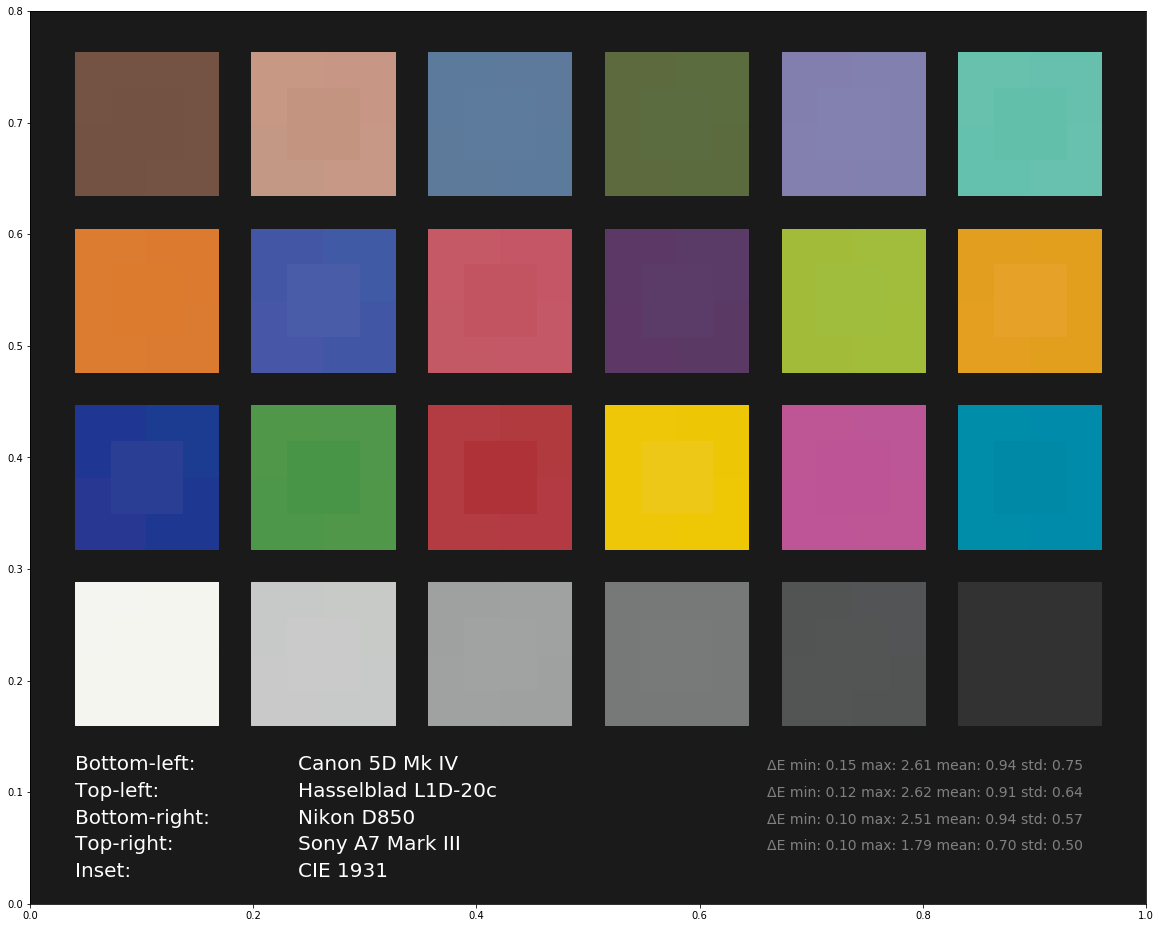

In [41]:
canon_5dmkiv = load_camera_data('canon_eos-5d-mkiv_380_720_10.json').align(SpectralShape(360, 830, 1))
rgb_canon_5dmkiv_d65 = sd_to_CameraRGB(colour.sd_ones(), canon_5dmkiv, illuminant = sd_d65) / 100
mtx_canon_5dmkiv = solve_matrix(canon_5dmkiv, sd_d65, sd_d65, rgb_canon_5dmkiv_d65)
chart_canon_5dmkiv = create_chart(canon_5dmkiv, sd_d65, sd_d65, mtx_canon_5dmkiv, rgb_canon_5dmkiv_d65)

hasselblad_l1d = load_camera_data('hasselblad_l1d-20c_380_720_10.json').align(SpectralShape(360, 830, 1))
rgb_hasselblad_l1d_d65 = sd_to_CameraRGB(colour.sd_ones(), hasselblad_l1d, illuminant = sd_d65) / 100
mtx_hasselblad_l1d = solve_matrix(hasselblad_l1d, sd_d65, sd_d65, rgb_hasselblad_l1d_d65)
chart_hasselblad_l1d = create_chart(hasselblad_l1d, sd_d65, sd_d65, mtx_hasselblad_l1d, rgb_hasselblad_l1d_d65)

nikon_d850 = load_camera_data('nikon_d850_380_720_10.json').align(SpectralShape(360, 830, 1))
rgb_nikon_d850_d65 = sd_to_CameraRGB(colour.sd_ones(), nikon_d850, illuminant = sd_d65) / 100
mtx_nikon_d850 = solve_matrix(nikon_d850, sd_d65, sd_d65, rgb_nikon_d850_d65)
chart_nikon_d850 = create_chart(nikon_d850, sd_d65, sd_d65, mtx_nikon_d850, rgb_nikon_d850_d65)

sony_a7m3 = load_camera_data('sony_ilce-7m3_380_720_10.json').align(SpectralShape(360, 830, 1))
rgb_sony_a7m3_d65 = sd_to_CameraRGB(colour.sd_ones(), sony_a7m3, illuminant = sd_d65) / 100
mtx_sony_a7m3 = solve_matrix(sony_a7m3, sd_d65, sd_d65, rgb_sony_a7m3_d65)
chart_sony_a7m3 = create_chart(sony_a7m3, sd_d65, sd_d65, mtx_sony_a7m3, rgb_sony_a7m3_d65)

draw_chart([chart_canon_5dmkiv, chart_hasselblad_l1d, chart_nikon_d850, chart_sony_a7m3, chart_bca], labels=['Canon 5D Mk IV', 'Hasselblad L1D-20c', 'Nikon D850', 'Sony A7 Mark III', 'CIE 1931'])
